In [1]:
!nvidia-smi
import pickle 
import matplotlib.pyplot as plt
import random
import numpy as np
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

Sat Oct  3 19:56:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!unzip '/content/drive/My Drive/LLD-icon_PKL.zip'

Archive:  /content/drive/My Drive/LLD-icon_PKL.zip
   creating: LLD-icon/
  inflating: LLD-icon/LLD-icon_data_2.pkl  
  inflating: LLD-icon/LLD-icon_data_0.pkl  
  inflating: LLD-icon/LLD-icon_data_3.pkl  
  inflating: LLD-icon/LLD-icon_data_4.pkl  
  inflating: LLD-icon/LLD-icon_data_1.pkl  


In [3]:
with open('/content/LLD-icon/LLD-icon_data_0.pkl', 'rb') as f:
    part1 = pickle.load(f, encoding='ISO-8859-1')
with open('/content/LLD-icon/LLD-icon_data_1.pkl', 'rb') as f:
    part2 = pickle.load(f, encoding='ISO-8859-1')
with open('/content/LLD-icon/LLD-icon_data_2.pkl', 'rb') as f:
    part3 = pickle.load(f, encoding='ISO-8859-1')
with open('/content/LLD-icon/LLD-icon_data_3.pkl', 'rb') as f:
    part4 = pickle.load(f, encoding='ISO-8859-1')
with open('/content/LLD-icon/LLD-icon_data_4.pkl', 'rb') as f:
    part5 = pickle.load(f, encoding='ISO-8859-1')   

(32, 32, 3)


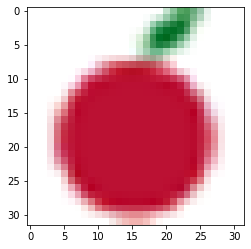

In [37]:
i=random.randint(0,10000)
plt.imshow(part1[i,:,:])
print(part1[i,:,:].shape)

In [4]:
train_df=np.concatenate([part1,part2])

In [15]:
class WGAN():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
  

    def build_generator(self):
        model = Sequential()
        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((8, 8, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)
        
    def train(self, epochs, train_df, batch_size=400, sample_interval=50):

        # Load the dataset
        X_train=train_df

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        #X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))
            self.critic.save("/content/drive/My Drive/discriminator.h5")
            self.generator.save("/content/drive/My Drive/generator.h5")
            self.combined.save("/content/drive/My Drive/combined.h5")
            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("/content/drive/My Drive/image_%d.png" % epoch)
        plt.close()

   

In [16]:
wgan = WGAN()
wgan.train(epochs=4000, train_df=train_df, batch_size=40, sample_interval=50)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 16, 16, 16)        448       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 32)          4640      
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 9, 9, 32)          0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 9, 9, 32)          128       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 9, 9, 32)         

In [17]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c,100))

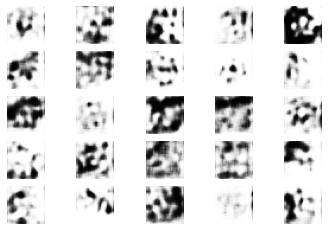

In [20]:
gen_imgs = wgan.generator.predict(noise)

        # Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
        for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
fig.savefig("/content/drive/My Drive/image_%d.png")